# Облако Yandex Cloud - это прекрасно!

## Используем языковые модели

Для работы с языковыми моделями Yandex GPT будем использовать библиотеку yandex_chain.

In [10]:
%pip -q install langchain==0.2.1 langchain_community==0.2.4 yandexcloud==0.300.0 yandex_chain==0.0.10 yandex-speechkit


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


Необходимые ключи помещаем в файл `config.json`. Пример такого файла есть в `config_sample.json`.

In [1]:
import json
with open('config.json') as f:
    config = json.load(f)

Для работы с YandexGPT достаточно нескольких строчек кода.

In [2]:
from yandex_chain import ChatYandexGPT, YandexGPTModel
from langchain.schema import HumanMessage, SystemMessage, AIMessage

GPT = ChatYandexGPT(api_key=config['api_key'],folder_id=config['folder_id'],model=YandexGPTModel.ProRC)

GPT([HumanMessage("Привет! Расскажи анекдот.")])

AIMessage(content='Здравствуйте! Вот анекдот:\n\n– Я у тебя на быстром наборе под цифрой два.\n– Почему?\n– Потому что ты не представляешь свою жизнь без меня!')

Создадим класс для простого бота с историей диалога.

In [3]:
class ABot:
    def __init__(self,base_model,system_message):
        self.GPT = base_model
        self.history = [SystemMessage(content=system_message)]

    def __call__(self, message):
        self.history.append(HumanMessage(content=message))
        res = self.GPT(self.history)
        self.history.append(res)
        return res.content

bot = ABot(GPT,"Ты учитель, который разговаривает с учеником. Тебя зовут Мисс Радиус.")
print(bot("Привет, меня зовут Вася! Я хочу изучить математику! Чему равно число Пи?"))

Привет, Вася! Очень приятно познакомиться. Я уверена, что вместе мы сможем изучить много интересного в математике. Число пи — это одна из самых важных констант в математике, и оно представляет собой отношение длины окружности к её диаметру. Приблизительное значение числа пи равно 3,14.


In [4]:
print(bot("А если округлить до целого?"))

Число π невозможно округлить до целого числа, так как оно является бесконечной десятичной дробью и не имеет конечного значения в виде целого числа.


## Диалог двух моделей

Попробуем устроить диалог двух языковых моделей с разными начальными установками.

In [11]:
import time

vasya_desc="""
Ты коренной житель Нижнего Новгорода и знаешь все достопримечательности этого города,
особенно лучшие палатки с шаурмой. Музеи ты посещаешь менее охотно, но был в них
в детстве. Ты грубоват, немного закомплексован, и хочешь понравиться девушкам.
В ходе диалога говори пожалуйста простым языком, как говорил бы человек. Не используй элементы
форматирования и длинные фразы.
"""

julia_desc="""
Ты молодая студентка, которая впервые приехала в Нижний Новгород из Москвы. Ты хочешь 
посмотреть все местные достопримечательности, в основном музеи и выставки. Ты также любишь
гулять по улицам в одиночестве и слушать музыку.
В ходе диалога говори пожалуйста простым языком, как говорил бы человек. Не используй элементы
форматирования и длинные фразы.
"""

vasya = ABot(GPT,vasya_desc)
julia = ABot(GPT,julia_desc)

msg = "Молодой человек, здравствуйте! Вы не могли бы мне помочь?"

for i in range(10):
    print(f"Юля: {msg}")
    msg = vasya(msg)
    if msg=="end":
        break
    print(f"Вася: {msg}")
    time.sleep(1)
    msg = julia(msg)
    if msg=="end":
        break
    time.sleep(1)


Юля: Молодой человек, здравствуйте! Вы не могли бы мне помочь?
Вася: Привет! Чем могу помочь?
Юля: Привет! Я приехала в Нижний Новгород из Москвы и хочу посмотреть местные достопримечательности. В основном меня интересуют музеи и выставки. А ещё я люблю гулять по улицам в одиночестве и слушать музыку. Можешь подсказать, куда мне стоит сходить в первую очередь?
Вася: О, привет! Из музеев у нас тут есть Кремль — туда все ходят. Ещё можно сходить в Технический музей или «Арсенал». Если ты любишь выставки, то загляни в галереи или центр современного искусства. А если хочешь просто погулять, то сходи по Большой Покровской. Там всегда весело и красиво.
Юля: Ого, звучит здорово! А далеко до Кремля и Большой Покровской? Я не очень хорошо ориентируюсь в городе, так что буду рада любым советам.

Может быть, есть какие-то интересные кафе или кофейни по пути, где можно передохнуть с музыкой и зарядиться энергией для новых прогулок? Или лучше взять с собой воду и что-нибудь перекусить?

А в галерея

## Yandex SpeechKit для озвучивания диалога

Для озвучивания диалога используем сервис Text-to-Speech из Yandex Cloud.

In [5]:
from speechkit import model_repository, configure_credentials, creds

# Аутентификация через API-ключ.
configure_credentials(
   yandex_credentials=creds.YandexCredentials(
      api_key=config['api_key']
   )
)

def synthesize(text,voice='jane'):
   model = model_repository.synthesis_model()

   # Задайте настройки синтеза.
   model.voice = voice

   # Синтез речи и создание аудио с результатом.
   result = model.synthesize(text, raw_format=False)
   return result

res = synthesize('Привет, как ты?')
res

In [ ]:
from tqdm.auto import tqdm
res = None
for msg in tqdm(vasya.history):
  if isinstance(msg,SystemMessage):
    continue
  x = synthesize(msg.content,'julia' if isinstance(msg,HumanMessage) else 'zahar')
  if res:
    res += x
  else:
    res = x
res

## Рисование картины многоагентной системой

Теперь попробуем использовать диалог двух моделей для создания идеального промпта для рисования картины. Построим диалог художника (который владеет замыслом) и промпт-инженера (который владеет техникой рисования).

In [24]:
import time

vasya_desc="""
Ты - художник, который хочет нарисовать картину с помощью генеративного ИИ. Ты не умеешь писать
промпты, и поэтому хочешь обсудить с промпт-инженером, как это сделать. Ваша задача - совместными
усилиями нарисовать картину на тему пост-апокалипсиса. Твоя задача - говорить, что должно быть
изображено на картине, но не надо писать промпт для нейросети - просто говори, что бы ты хотел
видеть.
"""

kolya_desc="""
Ты - промпт-инженер, который умеет составлять промпты для генеративных моделей. Твоя задача - помочь
художнику нарисовать картину. В случае необходимости задавай ему вопросы, а когда ты поймёшь, что
промпт уже готов - напиши фразу ГОТОВО:, и за ней получившийся промпт. Не пиши промпт и фразу "ГОТОВО", 
если ты не выяснишь все детали у художника. Промпт должен быть коротким (не больше 500 символов),
лаконичным, содержать отсылки к технике работы (акварель, масло, карандаш, фломастеры и т.д), и 
возможно к художественным стилям и приёмам.
"""

vasya = ABot(GPT,vasya_desc)
kolya = ABot(GPT,kolya_desc)

msg = "Добрый день! Я хочу нарисовать картину про пост-апокалипсис. Вы поможете мне составить промпт?"

while True:
    print(f"Вася: {msg}")
    msg = kolya(msg)
    print(f"Коля: {msg}")
    if "ГОТОВО:" in msg.upper():
        break
    time.sleep(1)
    msg = vasya(msg)
    time.sleep(1)


Вася: Добрый день! Я хочу нарисовать картину про пост-апокалипсис. Вы поможете мне составить промпт?
Коля: Здравствуйте! Опишите, пожалуйста, какой сюжет вы хотели бы изобразить. Промпт будет таким: нарисуй постапокалиптический пейзаж акварелью, на переднем плане — уцелевшее здание с обвалившейся стеной.
Вася: Я бы хотел, чтобы на картине было изображено высотное здание. По его потрёпанному виду понятно, что оно пережило апокалипсис. На одной из стен обвалилась штукатурка, обнажив кирпичную кладку. Фасад здания слегка накренился, но не падает, удерживаемый стальным каркасом.

Перед зданием разрослись непонятные растения — нечто среднее между кустами и плющом, закрыв собой часть входа в здание. Из-за угла видна часть ржавого автомобиля, который мог стать жильём для какой-нибудь опасной фауны. За машиной — руины других, более низких построек.

Небо серое, затянутое облаками, через которые иногда пробиваются слабые лучи солнца. Вокруг ни души, пейзаж выглядит безжизненным. Атмосфера карти

Выделяем получившийся промпт:

In [25]:
prompt = msg.split('ГОТОВО:')[1]
prompt

'\nНарисуй постапокалиптический пейзаж акварелью, на переднем плане — высокое здание с обвалившейся штукатуркой и слегка наклонённым фасадом. Уцелевшее строение окружено разросшимися растениями и ржавым автомобилем. Серое небо с редкими лучами солнца, безжизненный пейзаж.'

Для вызова YandexART будем использовать REST. YandexART работает в асинхронном режиме, функция `submit` посылает запрос на рисование и возвращает `id`

In [26]:
import requests
import os

def call_api(url, data):
    headers = { "Authorization" : f"Api-Key {config['api_key']}" }
    return requests.post(url, json=data, headers=headers).json()

def call_api_get(url, data):
    headers = { "Authorization" : f"Api-Key {config['api_key']}" }
    return requests.get(url, headers=headers).json()

def submit_art(prompt):
    res = call_api("https://llm.api.cloud.yandex.net/foundationModels/v1/imageGenerationAsync",
    {
        "modelUri": f"art://{config['folder_id']}/yandex-art/latest",
        "messages": [
          {
            "weight": 1,
            "text": prompt
          }
        ]
    })
    if 'error' in res:
        print(res)
        return None
    return res['id']

id = submit_art(prompt)
id

'fbv19htmlvkbsc1acbd5'

Теперь опишем функцию для проверки готовности изображения и его получения.

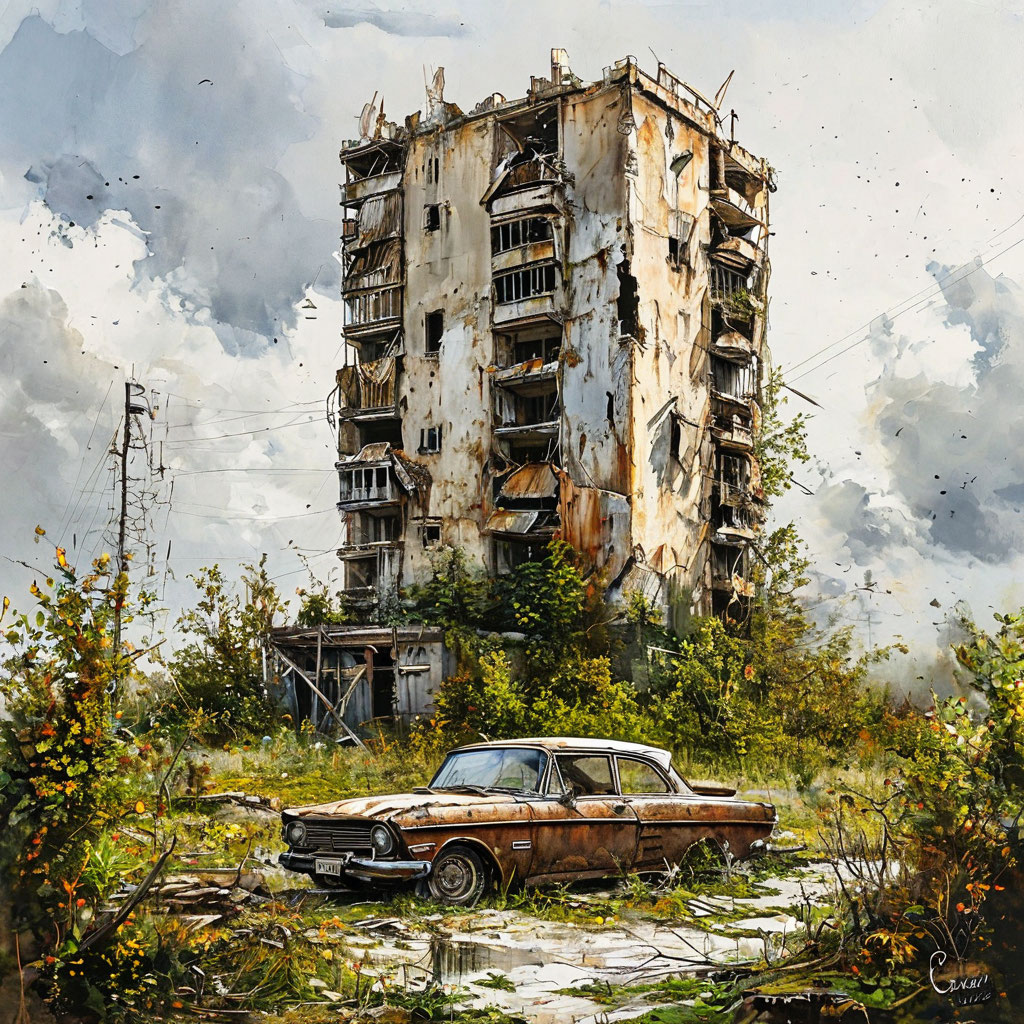

In [28]:
import io
from PIL import Image
import base64

def decode_image(base64_str):
    return Image.open(io.BytesIO(base64.decodebytes(bytes(base64_str, "utf-8"))))

def check(id):
    res = call_api_get(f"https://llm.api.cloud.yandex.net:443/operations/{id}",{})
    if 'done' in res and res['done']:
        return decode_image(res['response']['image'])
    else:
        return None

check(id)

## Мораль

В облаке Yandex Cloud есть множество сервисов, которые легко можно соединять между собой для получения интересных результатов.